# Tortuosity $\tau(x)$ of graded electrodes

In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import taufactor as tau

## 2D validation structures

Generate structures and visualise them...

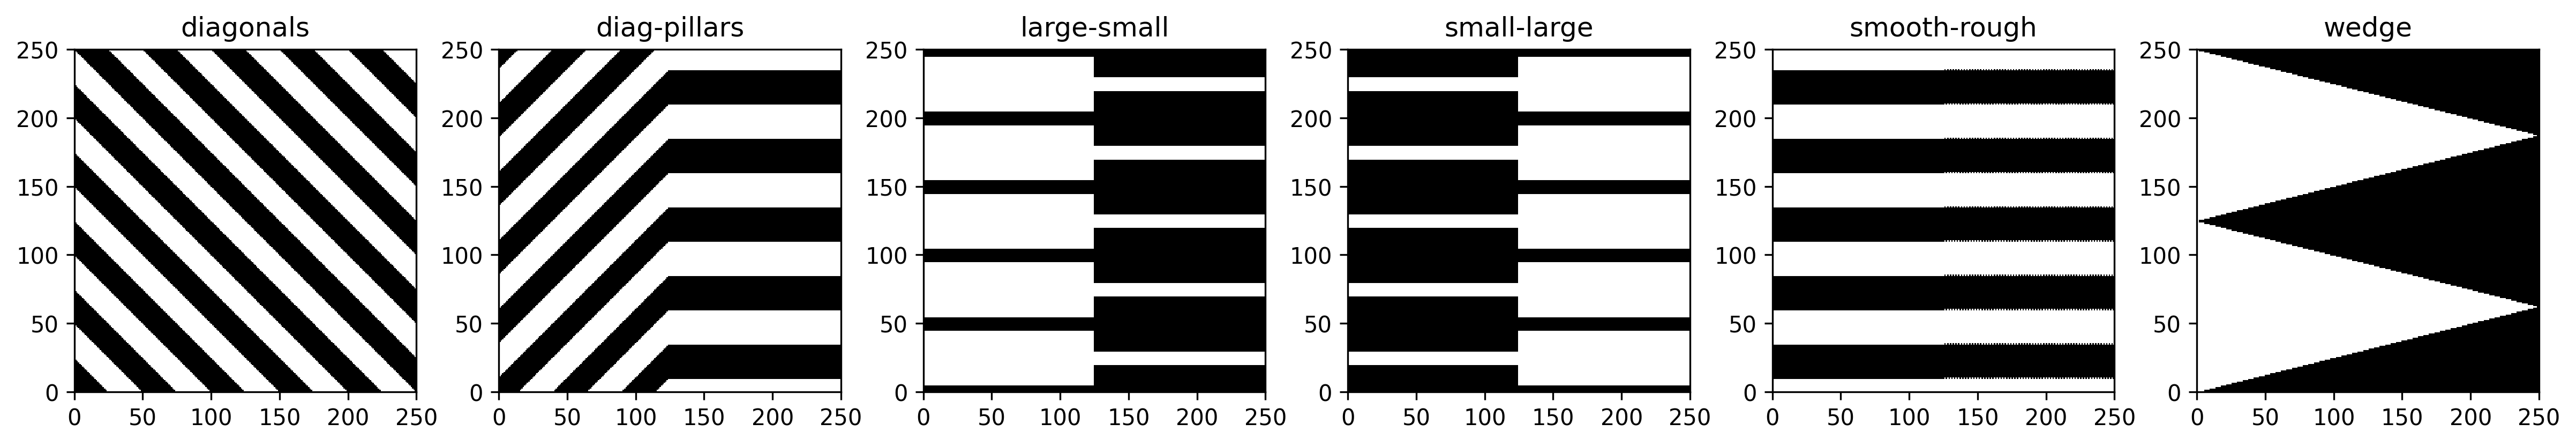

In [2]:
Lx = 100e-6
nx = 250

structures = ["diagonals", "diag-pillars", "large-small", "small-large", "smooth-rough", "wedge"]
fields = {}

cube_size = 25
x, y, z = np.ogrid[:nx, :nx, :1]

pattern = (((x + y + z) // cube_size) % 2)
fields["diagonals"] = pattern

pillars = x - x + ((y // cube_size) + (z // cube_size)) % 2
pattern = np.zeros((nx, nx, 1))
pattern[:125,:] = pillars[:125,:]
pattern[125:,:] = fields['diagonals'][:125,:]
fields["diag-pillars"] = np.roll(pattern[::-1,:,:], shift=10, axis=1)

pattern = np.zeros((nx, nx, 1))
pattern[:125,0:40] = 1
pattern[125:,15:25] = 1
pattern[:,50:100] = pattern[:,:50]
pattern[:,100:200] = pattern[:,:100]
pattern[:,200:250] = pattern[:,:50]
pattern = np.roll(pattern, shift=5, axis=1)
fields["large-small"] = pattern
fields["small-large"] = pattern[::-1,:,:].copy()

pattern = pillars.copy()
pattern[0::2, :, :] = np.roll(pattern[0::2, :, :], shift=1, axis=1)
pattern[:125,:] = pillars[:125,:]
fields["smooth-rough"] = np.roll(pattern, shift=10, axis=1)

pattern = np.zeros((nx, nx, 1))
mask = ((x+0.5)/nx + 4*(y+0.5)/nx < 2) & ((x+0.5)/nx - 4*(y+0.5)/nx < 0)
pattern[mask] = 1
pattern[:,125:] = pattern[:,:125][:,::-1]
pattern[-1,:] = 0
fields["wedge"] = pattern

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 8), dpi=300)
for i, structure in enumerate(structures):
    data2d = fields[structure][:, :, 0].T
    axes[i].imshow(data2d, cmap='gray', interpolation='none')
    axes[i].set_aspect('equal')
    axes[i].set_title(structure)
    axes[i].set_xlim(0, nx)
    axes[i].set_ylim(0, nx)

plt.tight_layout()
plt.show()

Then we compute the spatial microstructure descriptors $\epsilon(x)$, $a_\text{act}(x)$ and $\tau(x)$ from transport-reaction simulation:

Most tortuositiy solvers in taufactor can take batches of microstructures as an input. The only constraint is your GPU RAM. The slowest converging microstructure will determine the total runtime of the simulation i.e. if one structure is wildly different and takes much longer than all other structures to converge this might not be the most efficient approach.

In [3]:
batch = np.stack([fields[structure] for structure in structures], axis=0)
batch.shape

(6, 250, 250, 1)

Typically a convergence criterion of $10^{-3}$ is enough for convergence of $\tau$ but it could be that the concentration field is not fully converged yet. The spacing argument in the solver initiation is important to correctly scale the specific surface area determined from the microstructure.

In [4]:
s = tau.PeriodicElectrodeSolver(batch, device='cuda', spacing=Lx/nx)
tau_pore = s.solve(iter_limit=50000, conv_crit=1e-3)

converged to: [2.00723604 1.4835232  0.86330487 2.35625425 1.28433812 0.76093445] after: 1900 iterations in: 0.4991s (0.0003 s/iter)
GPU-RAM currently 8.09 MB (max allocated 11.09 MB; 23.07 MB reserved)


Use the available plotting options to check if your solver is converged. The ``verbose='debug'`` option shows the change in tortuosity values for all batch elements in one plot. We see that the scalar $\tau$ values plateau after a couple iterations.

Iter: 1900, conv error: 9.915E-04, tau: 2.35625 (batch element 3)


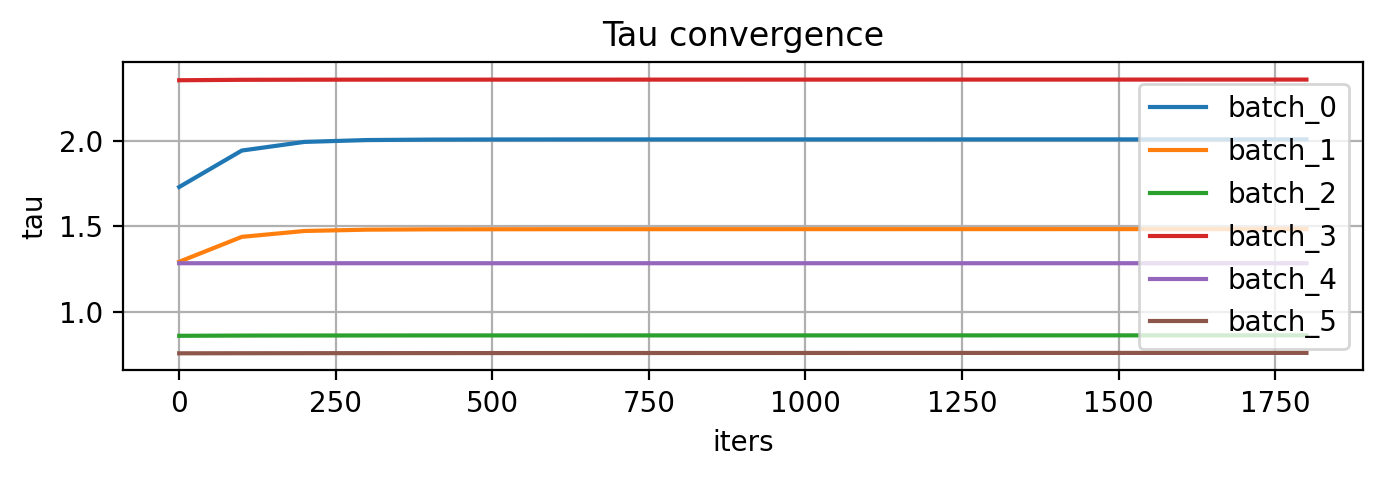

converged to: [2.00723604 1.4835232  0.86330487 2.35625425 1.28433812 0.76093445] after: 1900 iterations in: 2.4248s (0.0013 s/iter)
GPU-RAM currently 8.09 MB (max allocated 11.09 MB; 44.04 MB reserved)


In [5]:
s = tau.PeriodicElectrodeSolver(batch, device='cuda', spacing=Lx/nx)
tau_pore = s.solve(iter_limit=50000, conv_crit=1e-3, verbose='debug', plot_interval=1)

However, the ``verbose='plot'`` option which shows the relevant metrics for the batch element with the highest convergence error shows that the field are not really fully converged yet. Ideally the green curve should have a value of close to zero everywhere in the domain.

Iter: 200000, conv error: 2.244E-05, tau: 2.35396 (batch element 3)


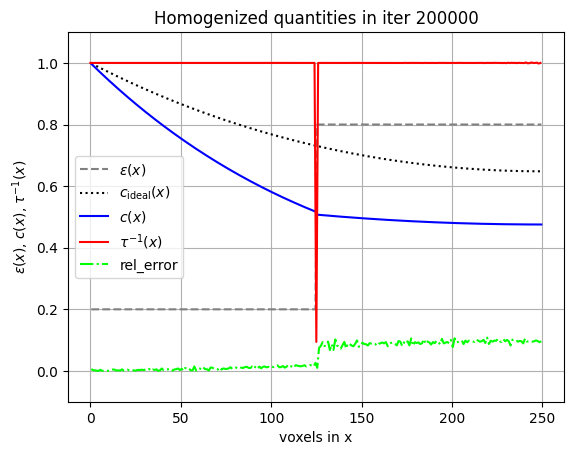

unconverged value of tau: [2.00811413 1.48497729 0.86372439 2.35396027 1.28433012 0.7580865 ] after: 200000 iterations in: 74.8732s (0.0004 s/iter)
GPU-RAM currently 8.09 MB (max allocated 11.16 MB; 44.04 MB reserved)


In [6]:
s = tau.PeriodicElectrodeSolver(batch, device='cuda', spacing=Lx/nx)
tau_pore = s.solve(iter_limit=200000, conv_crit=1e-5, verbose='plot', plot_interval=100)

Interestingly, this has minor effects on the determined values of $\tau$ so it seems like we can actually already extract $\tau(x)$ from the transient of the simulation.

The printed values of $\tau$ correspond to the equivalent scalar $\tau_\text{EIS}$ values determined by feeding all microstructure descriptors $\epsilon(x)$, $a_\text{act}(x)$ and $\tau(x)$ into a transmission line model. The actual spatial descriptors can be queried from the solver object as ``s.eps_x``, ``s.a_x`` and ``s.tau_x``. We extract them into dictionaries to plot them later on.

In [7]:
vol_x = {}
a_x = {}
tau_x = {}
c_x = {}
fields_c = {}
for i, structure in enumerate(structures):
    vol_x[structure] = s.vol_x[i]
    a_x[structure] = s.a_x[i]
    tau_x[structure] = s.tau_x[i]
    c_x[structure] = s.c_x[i]
    fields_c[structure] = s.field[i,1:-1,1:-1,1:-1].cpu().numpy()

# Smooth zigzag area data for better visualization
a_x['wedge'][1:-1] = np.mean(a_x['wedge'][1:-1])

/tmp/ipykernel_511676/2427557046.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


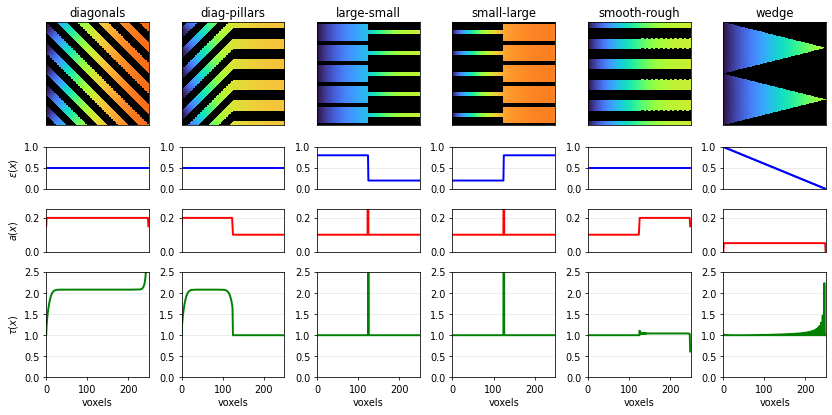

In [8]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 6), dpi=70,
                         constrained_layout=True,
                         gridspec_kw={'height_ratios': [1.0, 0.4, 0.4, 1]})
for i, structure in enumerate(structures):
    lw = 2
    data1 = fields_c[structure][:, :, 0].T
    data2 = fields[structure][:, :, 0].T
    alpha = np.clip(data2==0, 0, 1).astype(float)
    # Plot the concentration in turbo plus mask in black
    axes[0, i].imshow(data1, cmap='turbo_r', interpolation='none', vmin=0.3, vmax=1)
    axes[0, i].imshow(data2, cmap='gray', interpolation='none', alpha=alpha)
    axes[0, i].set_aspect('equal')
    axes[0, i].set_title(structure)
    # Set axis limits as needed (adjust these if necessary)
    axes[0, i].set_xlim(0, nx)
    axes[0, i].set_ylim(0, nx)
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    ax_line = axes[1, i]
    vx = np.asarray(vol_x[structure]).squeeze()
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='blue', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 1)
    axes[1, i].set_xticks([])
    ax_line.grid(True, alpha=0.3)

    ax_line = axes[2, i]
    vx = np.asarray(a_x[structure]).squeeze() / 1e6
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='red', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 0.25)
    ax_line.set_yticks([0,0.2])
    ax_line.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[2, i].set_xticks([])
    ax_line.grid(True, alpha=0.3)

    ax_line = axes[3, i]
    vx = np.asarray(tau_x[structure]).squeeze()
    xv = np.linspace(0, nx, num=vx.size, endpoint=False)
    ax_line.plot(xv, vx, color='green', linewidth=lw)
    ax_line.set_xlim(0, nx)
    ax_line.set_ylim(0, 2.5)
    ax_line.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_line.grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylabel('$\\epsilon(x)$')
    axes[2, 0].set_ylabel('$a(x)$')
    axes[3, 0].set_ylabel('$\\tau(x)$')
    ax_line.set_xlabel('voxels')

plt.tight_layout()
plt.show()

## Battery electrode example

For this exemplary analysis, we use a three-phase electrode (pore, NMC and carbon-binder-domain) which has been generated by Polaron. The generator was trained on the openly available dataset of a commercial NMC electrode from x-ray tomography [Usseglio-Viretta et. al. 2018](https://iopscience.iop.org/article/10.1149/2.0731814jes/pdf).

Stack shape: (256, 256, 256)


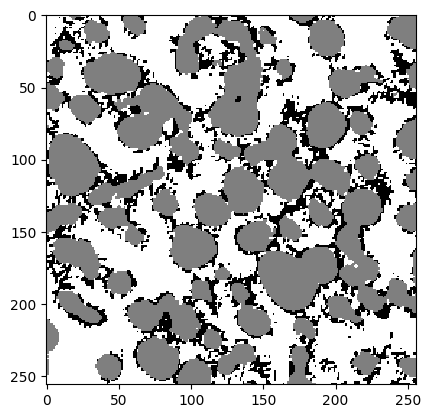

In [9]:
electrode = tifffile.imread('electrode.tiff')
print("Stack shape:", electrode.shape)

labels = {"pore":0, "NMC":85, "CBD":170}
boxsize = 100e-6 # physical domain in m
px = boxsize/electrode.shape[0] # pixel resolution in m

plt.imshow(electrode[:,:,0].T, cmap='gray_r', interpolation='none')
plt.show()

Determine overall volume fractions and surface areas

In [10]:
vol_frac = tau.metrics.volume_fraction(electrode , labels)
print("volume fractions: " + str(vol_frac))

surface_areas = tau.metrics.specific_surface_area(electrode, phases=labels, spacing=(px,px,px), method='face_counting')
print("specific surface areas: " + str(surface_areas))

volume fractions: {'pore': 0.44991737604141235, 'NMC': 0.40046632289886475, 'CBD': 0.1496163010597229}
specific surface areas: {'pore': 785502.4719238281, 'NMC': 374027.55737304693, 'CBD': 876099.5483398439}


Next, we check the connectivity of the pore phase. This is important as disconnected pores will slow down convergence and lead to large noise in the determined tortuosity $\tau(x)$.

In [11]:
through_fraction = {}
for key, value in labels.items():
    through_fraction[key] = {}
    _, through_fraction[key]['x'] = tau.metrics.extract_through_feature(electrode, value, 'x', connectivity=None)
    # _, through_fraction[key]['y'] = tau.metrics.extract_through_feature(electrode, value, 'y', connectivity=None)
    # _, through_fraction[key]['z'] = tau.metrics.extract_through_feature(electrode, value, 'z', connectivity=None)

print( "With |  side  |  edge  | corner | connectivity")
for key, value in labels.items():
    print(f" x = | {through_fraction[key]['x'][0]:.4f} | {through_fraction[key]['x'][1]:.4f} | {through_fraction[key]['x'][2]:.4f} | % of {key} are connected")
    # print(f" y = | {through_fraction[key]['y'][0]:.4f} | {through_fraction[key]['y'][1]:.4f} | {through_fraction[key]['y'][2]:.4f} | % of {key} are connected")
    # print(f" z = | {through_fraction[key]['z'][0]:.4f} | {through_fraction[key]['z'][1]:.4f} | {through_fraction[key]['z'][2]:.4f} | % of {key} are connected")

With |  side  |  edge  | corner | connectivity
 x = | 0.9989 | 0.9995 | 0.9996 | % of pore are connected
 x = | 0.9611 | 0.9612 | 0.9612 | % of NMC are connected
 x = | 0.9740 | 0.9915 | 0.9936 | % of CBD are connected


If ``extract_through_feature`` is called with ``connectivity=None``, then all three possible connectivity types will be checked. The meaning of connectivity types in 3D is:
- 1: faces (each voxel has 6 touching neighbours),
- 2: faces + edges (18 neighbours),
- 3: faces + edges + corners (26 neighbours).

The first type is relevant for our simulations as the finite difference stencil used in this case is based on face-touching neighbours. All other connectivity types (e.g. two pore voxels connected only by sharing an edge or a corner) will appear disconnected in the numerical scheme.

Finally, we determine the spatial tortuosity $\tau(x)$.
Note that we're using the ``ElectrodeSolver`` here as this microstructure is not periodic while previously the ``PeriodicElectrodeSolver`` was used.

Defining the conductive label as ``conductive_label=labels["pore"]`` means we're solving for transport in the electrolyte domain while ``reactive_label=labels["NMC"]`` defines all pairwise interfaces between pore and NMC as active for the intercalation reaction. All other labels are considered inactive i.e. they do neither contribute to transport nor are they active for intercalation.

Iter: 3000, conv error: 2.516E-04, tau: 2.07289 (batch element 0)


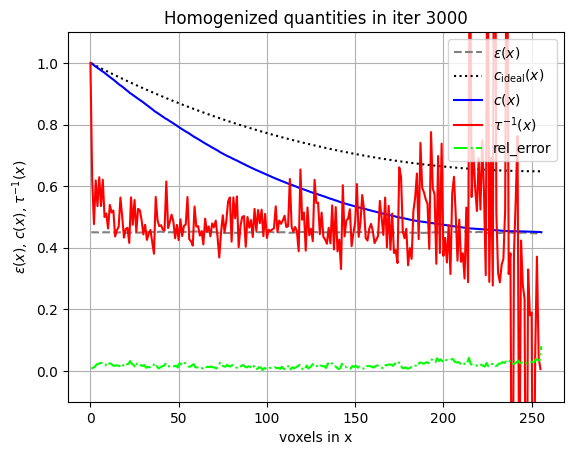

converged to: [2.07291984] after: 3800 iterations in: 59.3405s (0.0156 s/iter)
GPU-RAM currently 339.74 MB (max allocated 473.96 MB; 805.31 MB reserved)


In [12]:
s = tau.ElectrodeSolver(electrode, device='cuda', spacing=px,
                        conductive_label=labels["pore"], reactive_label=labels["NMC"])
tau_electrode = s.solve(iter_limit=50000, conv_crit=1e-4, plot_interval=10, verbose='plot')

As mentioned earlier, disconnected pores contributed massively to wrong slice averages of concentration, fluxes and, thus, tortuosity values. We therefore extract the connected feature first and re-label all connected pores before solving.

Iter: 3000, conv error: 2.388E-04, tau: 2.06577 (batch element 0)


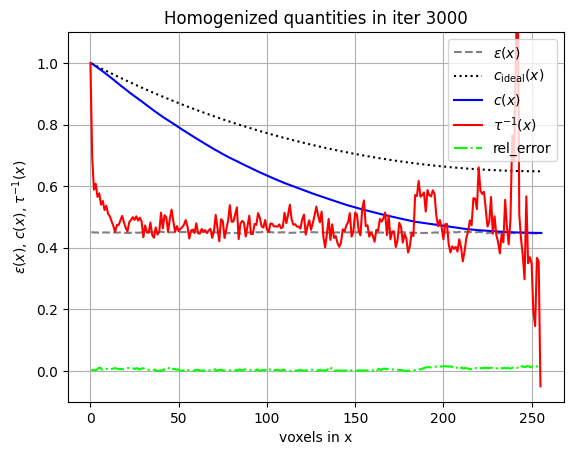

converged to: [2.06580016] after: 3800 iterations in: 59.3753s (0.0156 s/iter)
GPU-RAM currently 679.48 MB (max allocated 813.69 MB; 1012.92 MB reserved)


In [13]:
feature, _ = tau.metrics.extract_through_feature(electrode, labels["pore"], 'x', open_end=False)
labels["connected_pore"] = 1
electrode[feature[0]==1] = labels["connected_pore"]

s = tau.ElectrodeSolver(electrode, device='cuda', spacing=px,
                        conductive_label=labels["connected_pore"], reactive_label=labels["NMC"])
tau_electrode = s.solve(iter_limit=50000, conv_crit=1e-4, plot_interval=10, verbose='plot')

The tortuosity profiles can still be noisy depending on the cube size in the $y$-$z$-plane. But generally we never need such high resolution (in this case $256$ sample points in $x$-direction as the cube is $256^3$) because cell models like [PyBaMM](https://pybamm.org/) typically work with 20-50 grid points along the thickness direction of the electrode. Therefore, we can smooth the curves by downsampling and taking the correct volume averages for these quantities. Be careful with $\tau(x)$ as it is not just the arithmetic mean!

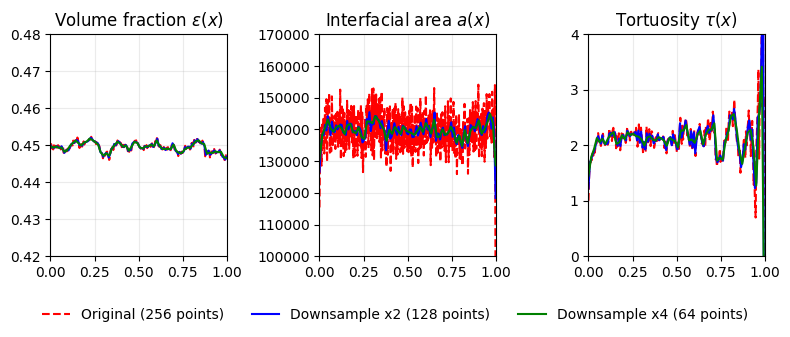

In [14]:
def downsample_and_plot(s, factor, color='blue'):
    M = len(s.vol_x[0]) // factor
    vol_xc = s.vol_x[0][:M*factor].reshape(M, factor).mean(axis=1)
    a_xc = s.a_x[0][:M*factor].reshape(M, factor).mean(axis=1)
    tau_xc = (s.tau_x[0]/s.vol_x[0])[:M*factor].reshape(M, factor).mean(axis=1) * vol_xc
    x_down = np.linspace(0, 1, vol_xc.shape[0])
    axes[0].plot(x_down, vol_xc, color=color, label=f'Downsample x{factor} ({x_down.size} points)')
    axes[1].plot(x_down, a_xc, color=color)
    axes[2].plot(x_down, tau_xc, color=color)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), dpi=100)
x_orig = np.linspace(0, 1, s.vol_x[0].shape[0])
axes[0].plot(x_orig, s.vol_x[0], 'r--', label=f'Original ({x_orig.size} points)')
axes[0].set_ylim(0.42, 0.48)
axes[1].plot(x_orig, s.a_x[0], 'r--')
axes[1].set_ylim(1e5, 1.7e5)
axes[2].plot(x_orig, s.tau_x[0], 'r--')
axes[2].set_ylim(0, 4)

downsample_and_plot(s, factor=2, color='blue')
downsample_and_plot(s, factor=4, color='green')

titles = ['Volume fraction $\\varepsilon(x)$', 'Interfacial area $a(x)$', 'Tortuosity $\\tau(x)$']
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.25)
fig.legend(loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()